In [1]:
from transformers import Sam3Processor, Sam3Model
import torch
from PIL import Image
import requests

device = "mps" if torch.cuda.is_available() else "cpu"
print(device)
model = Sam3Model.from_pretrained("facebook/sam3").to(device)
processor = Sam3Processor.from_pretrained("facebook/sam3")

# Load image
image_path = "./20240425_112716_nist-sand-30-100_27keV_z8mm_n2625_00000.tif"
image = Image.open(image_path).convert("RGB")

# Segment using text prompt
inputs = processor(images=image, text="sand", return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

# Post-process results
results = processor.post_process_instance_segmentation(
    outputs,
    threshold=0.5,
    mask_threshold=0.5,
    target_sizes=inputs.get("original_sizes").tolist()
)[0]

print(f"Found {len(results['masks'])} objects")
# Results contain:
# - masks: Binary masks resized to original image size
# - boxes: Bounding boxes in absolute pixel coordinates (xyxy format)
# - scores: Confidence scores


/Users/xiaoyachong/anaconda3/envs/sam3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


Loading weights: 100%|██████████| 1468/1468 [00:01<00:00, 1279.61it/s, Materializing param=vision_encoder.neck.fpn_layers.3.proj2.weight]                       


The OrderedVocab you are attempting to save contains holes for indices [1], your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains holes for indices [1], your vocabulary could be corrupted !
Found 0 objects


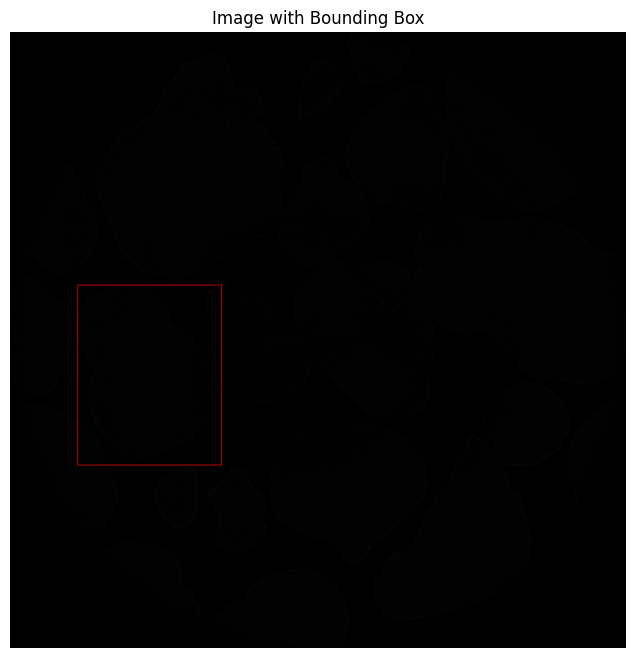

In [2]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Draw box on image for visualization
img_with_box = image.copy()
draw = ImageDraw.Draw(img_with_box)
box = [280, 1050, 880, 1800]
draw.rectangle(box, outline="red", width=3)

# Display inline in notebook
plt.figure(figsize=(10, 8))
plt.imshow(img_with_box)
plt.axis('off')  # Hide axes
plt.title('Image with Bounding Box')
plt.show()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [

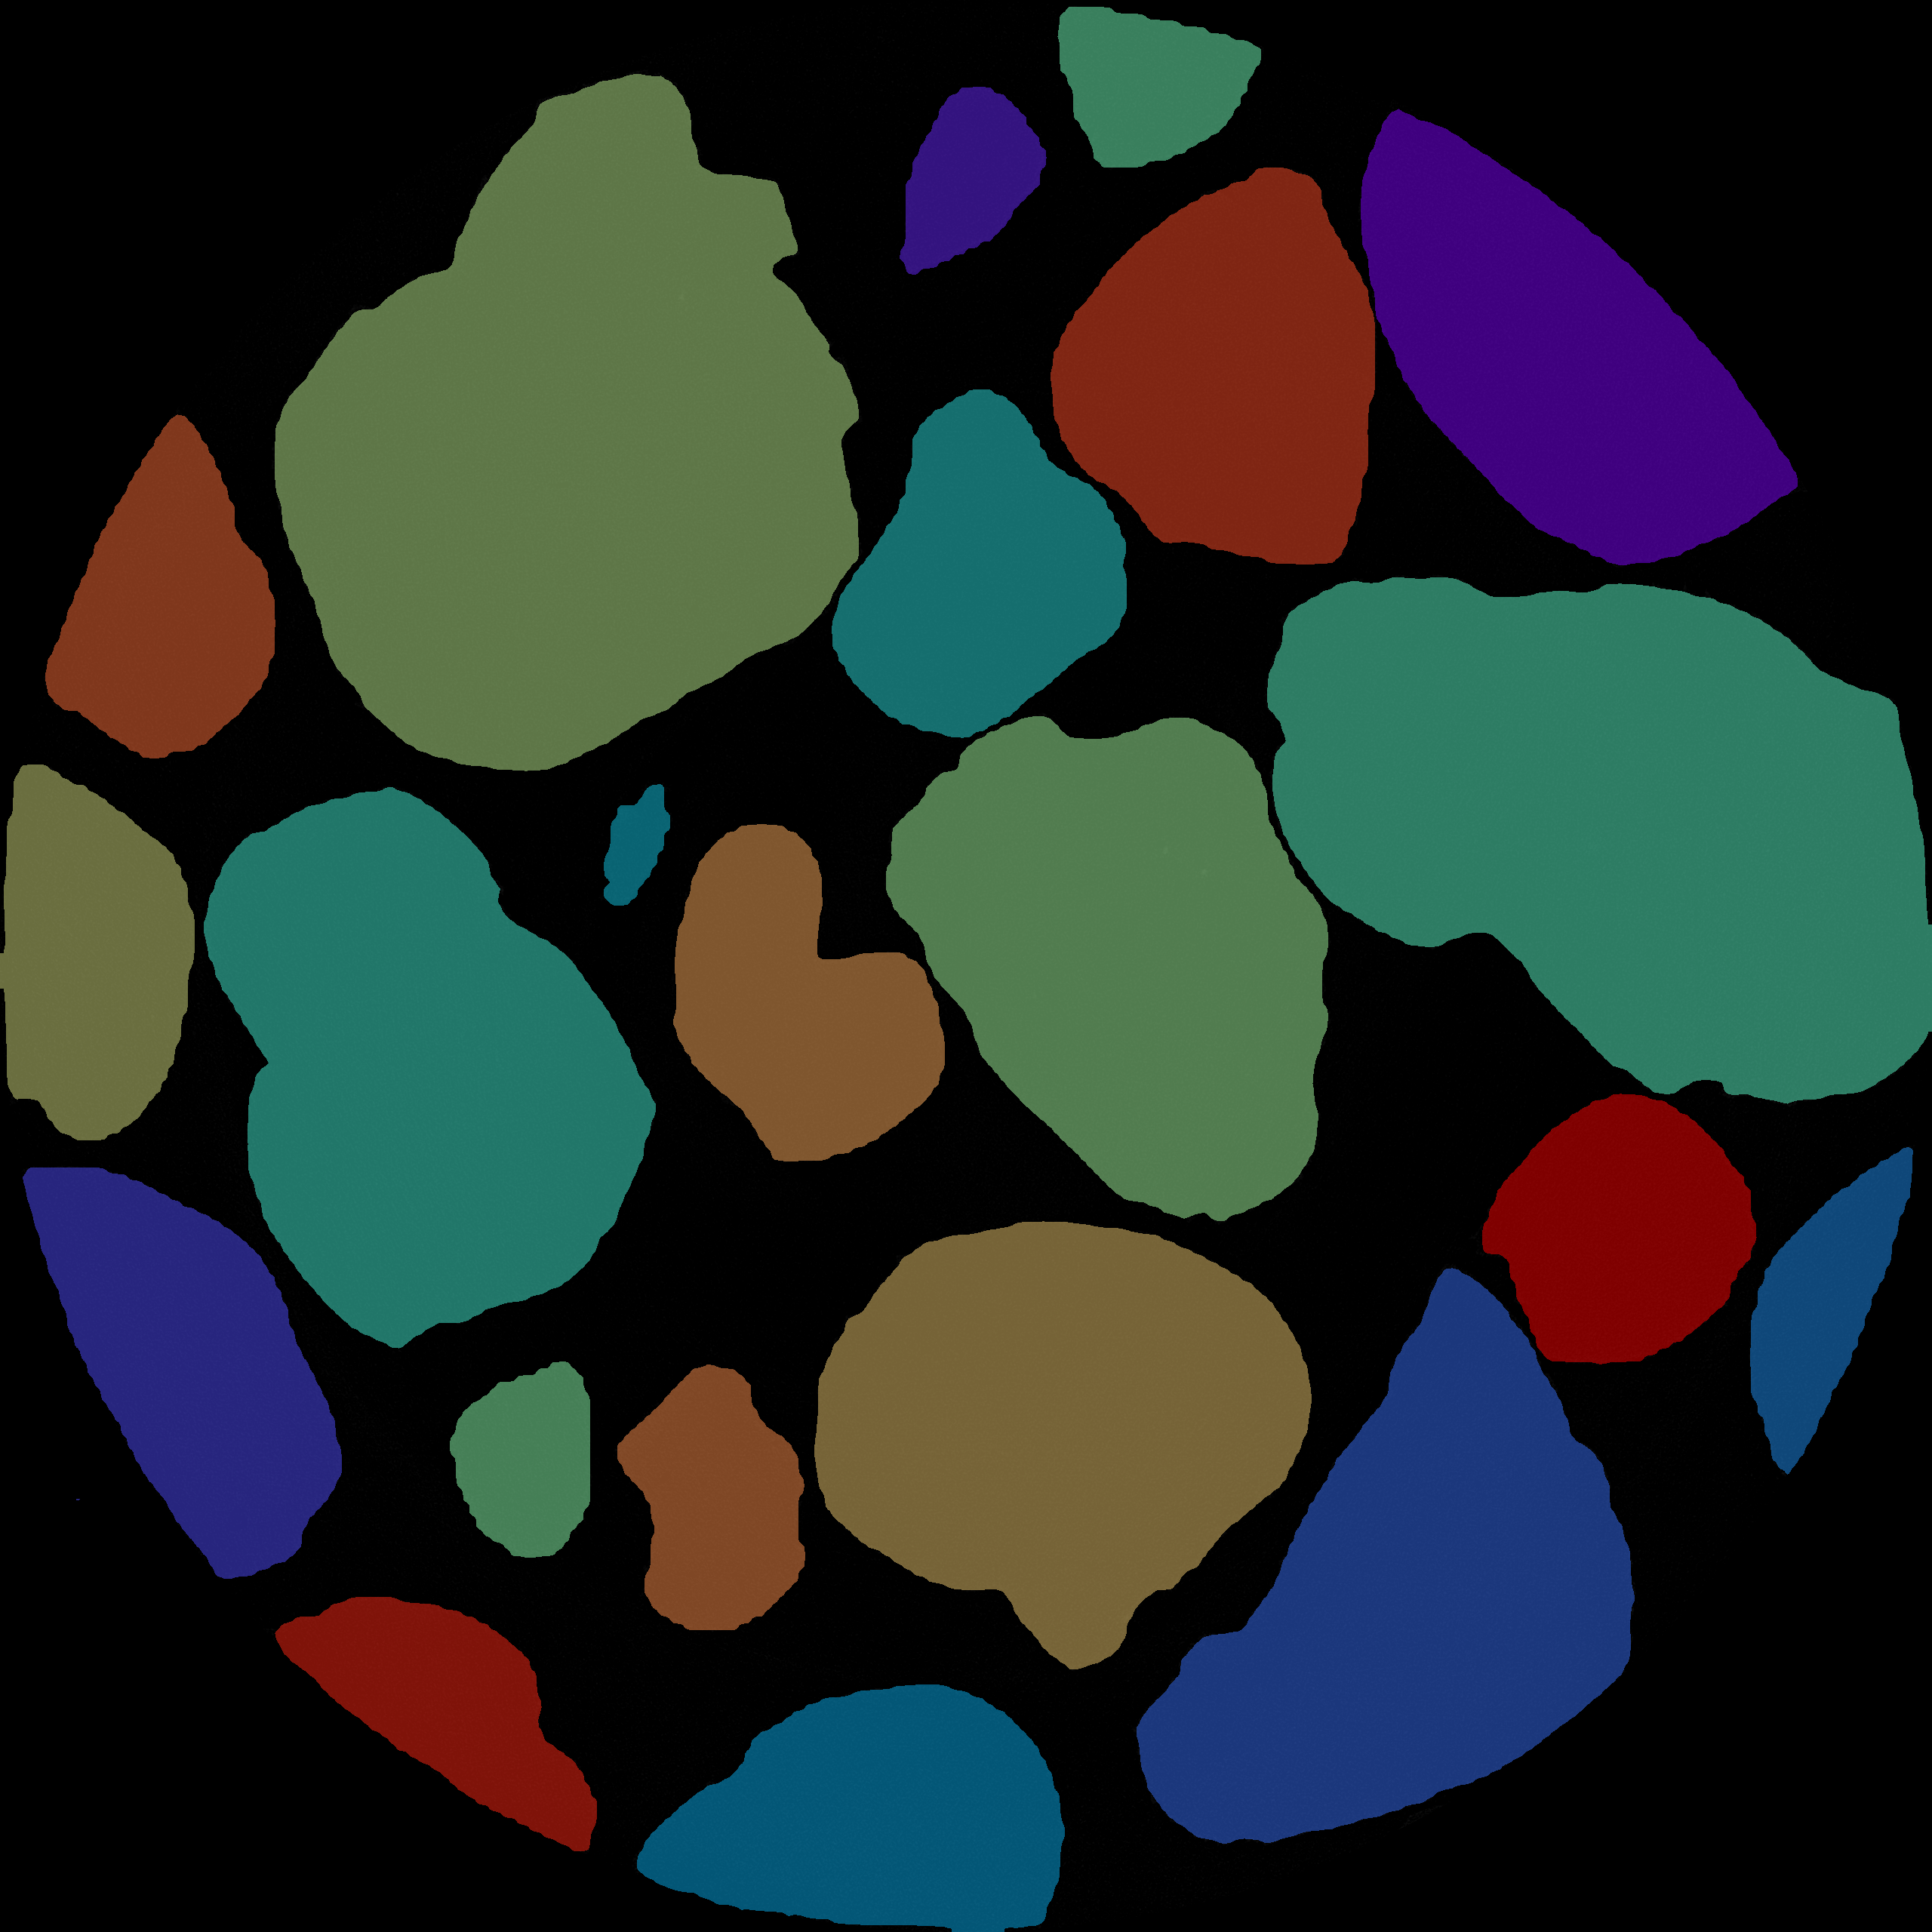

In [3]:
import numpy as np
import matplotlib
# Box in xyxy format: [x1, y1, x2, y2] in pixel coordinates
# Example: laptop region
box_xyxy = [280, 1050, 880, 1800]
input_boxes = [[box_xyxy]]  # [batch, num_boxes, 4]
input_boxes_labels = [[1]]  # 1 = positive box

inputs = processor(
    images=image,
    input_boxes=input_boxes,
    input_boxes_labels=input_boxes_labels,
    return_tensors="pt"
).to(device)

with torch.no_grad():
    outputs = model(**inputs)

# Post-process results
results = processor.post_process_instance_segmentation(
    outputs,
    threshold=0.5,
    mask_threshold=0.5,
    target_sizes=inputs.get("original_sizes").tolist()
)[0]

def overlay_masks(image, masks):
    image = image.convert("RGBA")
    masks = 255 * masks.cpu().numpy().astype(np.uint8)
    
    n_masks = masks.shape[0]
    cmap = matplotlib.colormaps.get_cmap("rainbow").resampled(n_masks)
    colors = [
        tuple(int(c * 255) for c in cmap(i)[:3])
        for i in range(n_masks)
    ]

    for mask, color in zip(masks, colors):
        print(mask)
        mask = Image.fromarray(mask)
        overlay = Image.new("RGBA", image.size, color + (0,))
        alpha = mask.point(lambda v: int(v * 0.5))
        overlay.putalpha(alpha)
        image = Image.alpha_composite(image, overlay)
    return image

overlay_masks(image, results["masks"])

